# Upgrade OpenCV in colab

**This upgrade is necessary to use the version 4 of YOLO**

In [1]:
pip install --upgrade opencv-python

     |████████████████████████████████| 49.9 MB 16 kB/s 
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.1.2.30
    Uninstalling opencv-python-4.1.2.30:
      Successfully uninstalled opencv-python-4.1.2.30
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [2]:
import numpy as np
import cv2
from google.colab.patches import cv2_imshow # colab do not support cv2.imshow()

# Variables

In [3]:
ROOT_COLAB = '/content/drive/MyDrive/Colab Notebooks/YOLO'
YOLO_CONFIG = ROOT_COLAB + '/oc_data/'
COCO_LABELS_FILE = YOLO_CONFIG + 'coco.names'
YOLO_CONFIG_FILE = YOLO_CONFIG + 'yolov4.cfg'
YOLO_WEIGHTS_FILE = YOLO_CONFIG + 'yolov4.weights'
LABELS_FROM_FILE = False
IMAGE_FILE = 'yoloimg.jpg'
IMAGE = cv2.imread(ROOT_COLAB + '/' + IMAGE_FILE)
CONFIDENCE_MIN = 0.5

# Show image

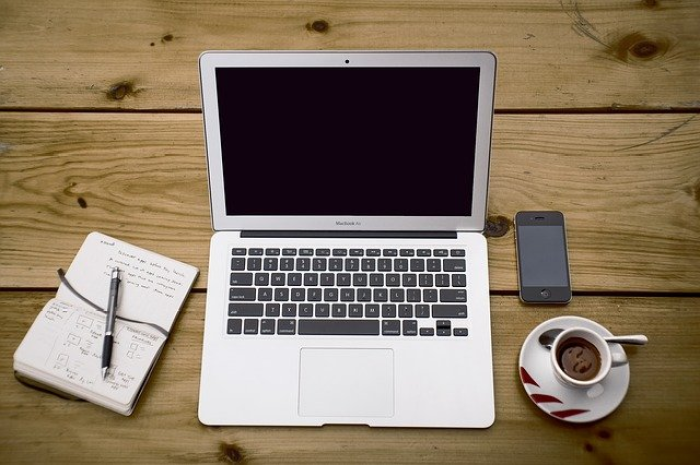

In [4]:
# Little function to resize in keeping the format ratio
# Source: https://stackoverflow.com/questions/35180764/opencv-python-image-too-big-to-display
def ResizeWithAspectRatio(_image, width=None, height=None, inter=cv2.INTER_AREA):
    dim = None
    image = _image.copy()
    (h, w) = image.shape[:2]
    if width is None and height is None:
        return image
    if width is None:
        r = height / float(h)
        dim = (int(w * r), height)
    else:
        r = width / float(w)
        dim = (width, int(h * r))
    return cv2.resize(image, dim, interpolation=inter)

cv2_imshow(ResizeWithAspectRatio(IMAGE, width=700)) 

In [5]:
(H, W) = IMAGE.shape[:2]
(H, W)

(426, 640)

## Read labels (only one in this case)

In [6]:
with open(COCO_LABELS_FILE, 'rt') as f:
    labels = f.read().rstrip('\n').split('\n')

## Color square initialisation (random)

Define for each label an specific color for the quares in the photo.

In [8]:
np.random.seed(45)
BOX_COLORS = np.random.randint(0, 255, size=(len(labels), 3), dtype="uint8")

# Prepare YOLO / OpenCV

Read the YOLO config & weights. (only for the V3 for the moment)

In [9]:
yolo = cv2.dnn.readNetFromDarknet(YOLO_CONFIG_FILE, YOLO_WEIGHTS_FILE)

Get the output layer only

In [10]:
yololayers = [yolo.getLayerNames()[i[0] - 1] for i in yolo.getUnconnectedOutLayers()]
yololayers

['yolo_139', 'yolo_150', 'yolo_161']

Prepare the Image (blog) to send it to the YOLO net

In [11]:
blobimage = cv2.dnn.blobFromImage(IMAGE, 1 / 255.0, (416, 416),	swapRB=True, crop=False)
yolo.setInput(blobimage)

# Apply YOLO / OpenCV

In [12]:
layerOutputs = yolo.forward(yololayers)
layerOutputs[0].shape

(8112, 85)

In [13]:
boxes_detected = []
confidences_scores = []
labels_detected = []

In [14]:
# loop over each of the layer outputs
for output in layerOutputs:
  # loop over each of the detections
  for detection in output:
    # extract the class ID and confidence (i.e., probability) of the current object detection
    scores = detection[5:]
    classID = np.argmax(scores)
    confidence = scores[classID]
    
    # Take only predictions with confidence more than CONFIDENCE_MIN thresold
    if confidence > CONFIDENCE_MIN:
      # Bounding box
      box = detection[0:4] * np.array([W, H, W, H])
      (centerX, centerY, width, height) = box.astype("int")

      # Use the center (x, y)-coordinates to derive the top and left corner of the bounding box
      x = int(centerX - (width / 2))
      y = int(centerY - (height / 2))

      # update our result list (detection)
      boxes_detected.append([x, y, int(width), int(height)])
      confidences_scores.append(float(confidence))
      labels_detected.append(classID)

## Brut Results

In [15]:
nb_results = len(boxes_detected)
nb_results

11

In [16]:
labels_detected

[67, 67, 67, 67, 67, 67, 67, 63, 63, 63, 67]

Use labels names instead ...

In [17]:
label_names = [labels[i] for i in labels_detected]
label_names

['cell phone',
 'cell phone',
 'cell phone',
 'cell phone',
 'cell phone',
 'cell phone',
 'cell phone',
 'laptop',
 'laptop',
 'laptop',
 'cell phone']

We can see here that we've detected duplicates (same) object like the cell phone (7 detections) whereas there's only one object for each of these classes.

In [18]:
confidences_scores

[0.9945502281188965,
 0.9963357448577881,
 0.5425968170166016,
 0.6487533450126648,
 0.9948509931564331,
 0.9954640865325928,
 0.9942308068275452,
 0.9818673729896545,
 0.9835858345031738,
 0.942979097366333,
 0.6356629729270935]

Confidences scores are all good (even for the duplicates)

In [19]:
boxes_detected

[[468, 187, 53, 91],
 [469, 187, 53, 93],
 [469, 194, 53, 88],
 [469, 191, 54, 91],
 [468, 192, 53, 88],
 [468, 191, 53, 89],
 [468, 191, 53, 89],
 [179, 42, 279, 354],
 [177, 42, 284, 353],
 [177, 40, 284, 360],
 [468, 187, 54, 93]]

In [20]:
len(boxes_detected)

11

# Display results in the image

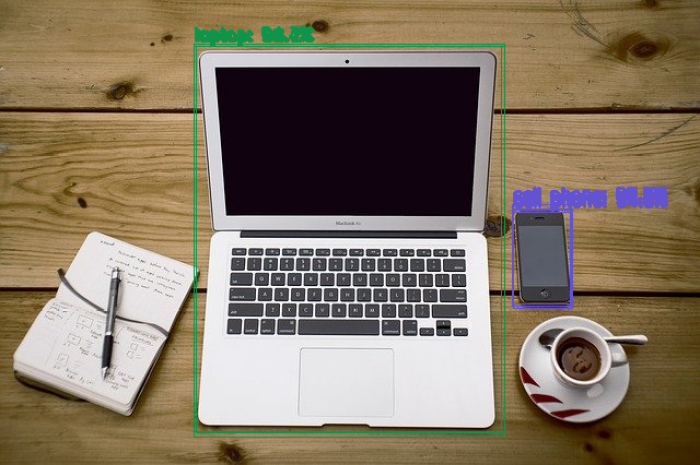

In [21]:
image = IMAGE.copy()
if nb_results > 0:
  for i in range(nb_results):
    # extract the bounding box coordinates
    (x, y) = (boxes_detected[i][0], boxes_detected[i][1])
    (w, h) = (boxes_detected[i][2], boxes_detected[i][3])
    # draw a bounding box rectangle and label on the image
    color = [int(c) for c in BOX_COLORS[labels_detected[i]]]
    cv2.rectangle(image, (x, y), (x + w, y + h), color, 1)
    score = str(round(float(confidences_scores[i]) * 100, 1)) + "%"
    text = "{}: {}".format(labels[labels_detected[i]], score)
    cv2.putText(image, text, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
  
cv2_imshow(ResizeWithAspectRatio(image, width=700))

Boxes seem to overlap ... in fact here we just have to remove the ovelapped boxes !

# Remove useless boxes by apply Non Max Suppression (NMS) technique
Hopefully OpenCV provides a function to Performs non maximum suppression given boxes and corresponding scores

Function cv2.dnn.NMSBoxes with these params:  
* bboxes	a set of bounding boxes to apply NMS.
* scores	a set of corresponding confidences.
* score_threshold	a threshold used to filter boxes by score.
* nms_threshold	a threshold used in non maximum suppression.

Applying the NMS technique will return only the selected max value by suppressing the non maximum (low confidence score) overlapping bounding boxes

In [22]:
final_boxes = cv2.dnn.NMSBoxes(boxes_detected, confidences_scores, 0.5, 0.5)

In [23]:
final_boxes

array([[1],
       [8]], dtype=int32)

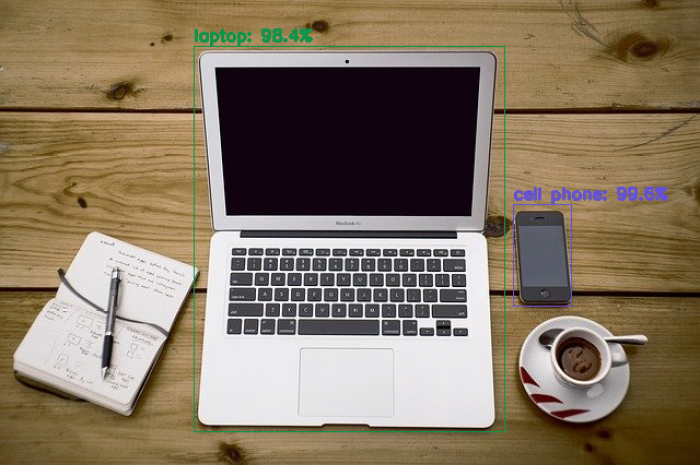

In [24]:
image = IMAGE.copy()
# loop through the final set of detections remaining after NMS and draw bounding box and write text
for max_valueid in final_boxes:
    max_class_id = max_valueid[0]

    # extract the bounding box coordinates
    (x, y) = (boxes_detected[max_class_id][0], boxes_detected[max_class_id][1])
    (w, h) = (boxes_detected[max_class_id][2], boxes_detected[max_class_id][3])

    # draw a bounding box rectangle and label on the image
    color = [int(c) for c in BOX_COLORS[labels_detected[max_class_id]]]
    cv2.rectangle(image, (x, y), (x + w, y + h), color, 1)
    
    score = str(round(float(confidences_scores[max_class_id]) * 100, 1)) + "%"
    text = "{}: {}".format(labels[labels_detected[max_class_id]], score)
    cv2.putText(image, text, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

cv2_imshow(ResizeWithAspectRatio(image, width=700))